<a href="https://colab.research.google.com/github/lej4545/AI_Project_Mask_Detection/blob/main/02_Projects/0826_LeeEunJin_Resnext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras # 텐서플로우 임포트
keras.__version__ # 버전 확인

'2.6.0'

In [ ]:
from google.colab import drive # 구글 드라이브에서 구글 colab 연동

In [ ]:
drive.mount('/content/drive') # 구글 드라이브 마운트

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os # os모듈 임포트
for dirname, _, filenames in os.walk('/content/drive/My Drive/PART1_ai_project_20210824_0830/02_Projects/03_LeeEunJin'):
    for filename in filenames: # 아마도 위에 폴더 안에 있는 파일들을 불러와서 
        os.path.join(dirname, filename) # 폴더 이름과 파일 이름을 합쳐주는 것 같다.

In [ ]:
import pandas as pd # 필요한 묘둘 임포트
import numpy as np
import seaborn as sns
from pandas import DataFrame

In [ ]:
traindir='/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/Train' # 학습할 데이터가 들어있는 폴더 경로
validdir='/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/Validation' #  검증하기 위한 데이터가 들어있는 폴더 경로
testdir='/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/Test' # 테스트 데이터가 들어있는 폴더 경로

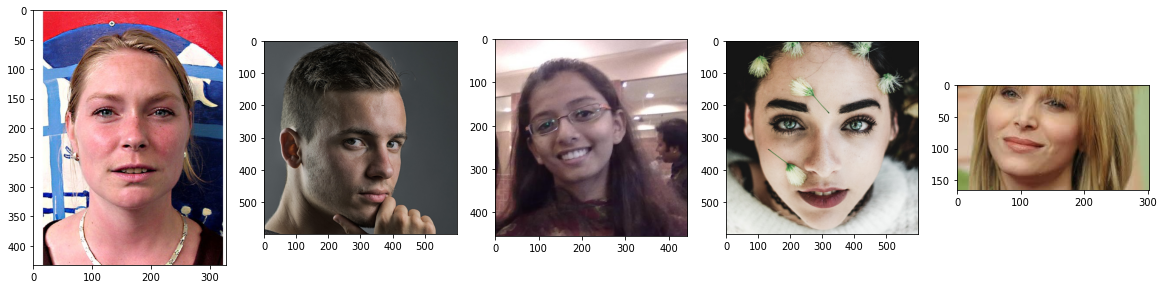

In [ ]:
path='/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/All'# 모든 이미지가 담겨있는 폴더
import cv2 
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20,20)) # 잘 불러오는지 확인하기 위해 임의의 5장 사진 출력
for i in range(5):
    file=random.choice(os.listdir(path)) # 디렉토리에 있는 파일 리스트를 가져온다.
    img_path=os.path.join(path,file)
    image=mpimg.imread(img_path)
    ax=plt.subplot(1,5,i+1)
    plt.imshow(image)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img #imagedatagenerator 임포트

# train_data, test_data 전처리
train_data=ImageDataGenerator(rescale=1.0/255, 
                              zoom_range=0.2,
                              shear_range=0.2,
                               rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              horizontal_flip=True)


# 이미지를 불러올 때 폴더명에 맞춰 자동으로 labelling 해준다.('WithMask' : 0 ,'WithoutMask' : 1) 이미지 사이즈는 224*224, 배치 사이즈는 32
train_generator = train_data.flow_from_directory(directory=traindir,target_size=(224, 224),class_mode='binary',batch_size=32)
test_data=ImageDataGenerator(rescale=1.0/255) 
# valid generator 도 train generator와 마찬가지로 진행
valid_generator = test_data.flow_from_directory(directory=validdir,target_size=(224, 224),class_mode='binary',batch_size=32)
# test 데이터도 train generator 에서 진행한 방식과 동일하고 추가적으로 rescaling을 진행
test_generator = test_data.flow_from_directory(directory=testdir,target_size=(224, 224),class_mode='binary',batch_size=32,shuffle=False)

print(valid_generator.class_indices)

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
{'WithMask': 0, 'WithoutMask': 1}


In [ ]:
# https://github.com/calmisential/ResNeXt_TensorFlow2
import tensorflow as tf
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import activations
from keras.models import Model

class GroupConv2D(tf.keras.layers.Layer):
    def __init__(self,
                 input_channels,
                 output_channels,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 groups=1,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(GroupConv2D, self).__init__()

        if not input_channels % groups == 0:
            raise ValueError("The value of input_channels must be divisible by the value of groups.")
        if not output_channels % groups == 0:
            raise ValueError("The value of output_channels must be divisible by the value of groups.")

        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.data_format = data_format
        self.dilation_rate = dilation_rate
        self.activation = activation
        self.groups = groups
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_constraint = bias_constraint

        self.group_in_num = input_channels // groups
        self.group_out_num = output_channels // groups
        self.conv_list = []
        for i in range(self.groups):
            self.conv_list.append(tf.keras.layers.Conv2D(filters=self.group_out_num,
                                                         kernel_size=kernel_size,
                                                         strides=strides,
                                                         padding=padding,
                                                         data_format=data_format,
                                                         dilation_rate=dilation_rate,
                                                         activation=activations.get(activation),
                                                         use_bias=use_bias,
                                                         kernel_initializer=initializers.get(kernel_initializer),
                                                         bias_initializer=initializers.get(bias_initializer),
                                                         kernel_regularizer=regularizers.get(kernel_regularizer),
                                                         bias_regularizer=regularizers.get(bias_regularizer),
                                                         activity_regularizer=regularizers.get(activity_regularizer),
                                                         kernel_constraint=constraints.get(kernel_constraint),
                                                         bias_constraint=constraints.get(bias_constraint),
                                                         **kwargs))

    def call(self, inputs, **kwargs):
        feature_map_list = []
        for i in range(self.groups):
            x_i = self.conv_list[i](inputs[:, :, :, i*self.group_in_num: (i + 1) * self.group_in_num])
            feature_map_list.append(x_i)
        out = tf.concat(feature_map_list, axis=-1)
        return out


class ResNeXt_BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filters, strides, groups):
        super(ResNeXt_BottleNeck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filters,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.group_conv = GroupConv2D(input_channels=filters,
                                      output_channels=filters,
                                      kernel_size=(3, 3),
                                      strides=strides,
                                      padding="same",
                                      groups=groups)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=2 * filters,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding="same")
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.shortcut_conv = tf.keras.layers.Conv2D(filters=2 * filters,
                                                    kernel_size=(1, 1),
                                                    strides=strides,
                                                    padding="same")
        self.shortcut_bn = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=None, **kwargs):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.group_conv(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn3(x, training=training)
        x = tf.nn.relu(x)

        shortcut = self.shortcut_conv(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        output = tf.nn.relu(tf.keras.layers.add([x, shortcut]))
        return output


def build_ResNeXt_block(filters, strides, groups, repeat_num):
    block = tf.keras.Sequential()
    block.add(ResNeXt_BottleNeck(filters=filters,
                                 strides=strides,
                                 groups=groups))
    for _ in range(1, repeat_num):
        block.add(ResNeXt_BottleNeck(filters=filters,
                                     strides=1,
                                     groups=groups))

    return block

In [ ]:

NUM_CLASSES = 1


class ResNeXt(tf.keras.Model):
    def __init__(self, repeat_num_list, cardinality):
        if len(repeat_num_list) != 4:
            raise ValueError("The length of repeat_num_list must be four.")
        super(ResNeXt, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")
        self.block1 = build_ResNeXt_block(filters=128,
                                          strides=1,
                                          groups=cardinality,
                                          repeat_num=repeat_num_list[0])
        self.block2 = build_ResNeXt_block(filters=256,
                                          strides=2,
                                          groups=cardinality,
                                          repeat_num=repeat_num_list[1])
        self.block3 = build_ResNeXt_block(filters=512,
                                          strides=2,
                                          groups=cardinality,
                                          repeat_num=repeat_num_list[2])
        self.block4 = build_ResNeXt_block(filters=1024,
                                          strides=2,
                                          groups=cardinality,
                                          repeat_num=repeat_num_list[3])
        self.pool2 = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=NUM_CLASSES,
                                        activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.block4(x, training=training)

        x = self.pool2(x)
        x = self.fc(x)

        return x


def ResNeXt50():
    return ResNeXt(repeat_num_list=[3, 4, 6, 3],
                   cardinality=32)


def ResNeXt101():
    return ResNeXt(repeat_num_list=[3, 4, 23, 3],
                   cardinality=32)

In [ ]:
input_layer = tf.keras.layers.Input(shape=(32, 32, 3))

model = ResNeXt50()

# 컴파일 단계는 훈련 과정을 설정합니다.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])


In [ ]:
# 데이터 학습
history = model.fit(train_generator,steps_per_epoch=len(train_generator)//8,epochs=20,validation_data=valid_generator, batch_size = 100)


Epoch 1/20
2/2 [==============================] - 196s 146s/step - loss: 2.4835 - accuracy: 0.4219 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/20
2/2 [==============================] - 186s 139s/step - loss: 0.9075 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 3/20
2/2 [==============================] - 180s 134s/step - loss: 0.8884 - accuracy: 0.5469 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 181s 139s/step - loss: 0.6683 - accuracy: 0.5312 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 5/20
2/2 [==============================] - 185s 140s/step - loss: 0.6541 - accuracy: 0.4219 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 186s 141s/step - loss: 0.6265 - accuracy: 0.5781 - val_loss: 0.7107 - val_accuracy: 0.5000
Epoch 7/20
2/2 [==============================] - 185s 139s/step - loss: 0.7731 - accuracy: 0.5469 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 8/20
2/

In [ ]:
# 학습된 모델 그래프로 plot하기
def plot_history(history):
    
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_history(history)

NameError: ignored